In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
from scipy.stats import ttest_ind
from numba import njit, jit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
meta = pd.read_csv('../data/META_SL.csv')

In [3]:
meta['plat'].unique()

array(['Agilent', 'Illumina_NGS', 'Affymetrix_U133', 'Illumina_Chip',
       'Affymetrix_HUG', 'Affymetrix_PRV'], dtype=object)

In [4]:
meta

,CN,type,plat,TP
0,C_1,Solid tumor,Agilent,Solid tumor_Agilent
1,C_2,Solid tumor,Agilent,Solid tumor_Agilent
2,C_3,Solid tumor,Agilent,Solid tumor_Agilent
3,C_4,Solid tumor,Agilent,Solid tumor_Agilent
4,C_5,Solid tumor,Agilent,Solid tumor_Agilent
...,...,...,...,...
7162,C_7163,C,Affymetrix_PRV,C_Affymetrix_PRV
7163,C_7164,D,Affymetrix_PRV,D_Affymetrix_PRV
7164,C_7165,D,Affymetrix_PRV,D_Affymetrix_PRV
7165,C_7166,D,Affymetrix_PRV,D_Affymetrix_PRV


#### Данные, на которых нужно проверить гипотезу

In [5]:
data = pd.read_csv('D:/data/00.csv')

In [6]:
data.head()

,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,C_7158,C_7159,C_7160,C_7161,C_7162,C_7163,C_7164,C_7165,C_7166,C_7167
A2M,57453.255954,41912.461522,45375.362565,84683.777259,74646.560384,51019.962756,58754.579564,56795.592871,62290.527928,32256.797978,...,15553.958360,15183.379792,102847.838451,98020.044948,97509.622648,107698.136707,81415.043084,80145.730239,77854.234759,74369.665285
AACS,1985.621570,1684.294226,1836.564456,1929.476483,1955.087088,1656.613597,1567.081911,1697.358275,2025.972566,2043.290169,...,488.950250,467.448792,426.835000,388.039931,386.191801,431.022479,470.833579,471.237944,458.805531,458.462123
AAK1,119.444129,130.700241,78.559232,73.481973,82.013134,63.990164,68.705771,84.673562,73.162797,157.969448,...,21221.972935,19665.752234,2050.288923,1843.272425,1746.072958,1802.065329,4803.145199,5139.830402,5431.749333,5954.088198
AAMP,5507.848612,4758.114528,4842.782282,5533.527990,7492.084794,4651.229571,4752.057635,4685.783720,5999.872323,8822.727914,...,3234.970089,3190.973264,3897.493126,3943.877495,3746.919862,4083.038882,3892.735175,4041.645388,4045.080383,4142.375150
AASDHPPT,1712.338211,2048.361608,1942.499198,1501.481463,1342.296147,2030.310640,1965.125120,1987.812402,1735.817670,1273.736125,...,5606.119964,5597.801274,3709.806293,3575.259505,3372.946174,3416.592452,3978.355392,5176.202750,3958.379861,4076.261587


In [7]:
data.columns = meta['CN']

In [8]:
data.head()

CN,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,C_7158,C_7159,C_7160,C_7161,C_7162,C_7163,C_7164,C_7165,C_7166,C_7167
A2M,57453.255954,41912.461522,45375.362565,84683.777259,74646.560384,51019.962756,58754.579564,56795.592871,62290.527928,32256.797978,...,15553.958360,15183.379792,102847.838451,98020.044948,97509.622648,107698.136707,81415.043084,80145.730239,77854.234759,74369.665285
AACS,1985.621570,1684.294226,1836.564456,1929.476483,1955.087088,1656.613597,1567.081911,1697.358275,2025.972566,2043.290169,...,488.950250,467.448792,426.835000,388.039931,386.191801,431.022479,470.833579,471.237944,458.805531,458.462123
AAK1,119.444129,130.700241,78.559232,73.481973,82.013134,63.990164,68.705771,84.673562,73.162797,157.969448,...,21221.972935,19665.752234,2050.288923,1843.272425,1746.072958,1802.065329,4803.145199,5139.830402,5431.749333,5954.088198
AAMP,5507.848612,4758.114528,4842.782282,5533.527990,7492.084794,4651.229571,4752.057635,4685.783720,5999.872323,8822.727914,...,3234.970089,3190.973264,3897.493126,3943.877495,3746.919862,4083.038882,3892.735175,4041.645388,4045.080383,4142.375150
AASDHPPT,1712.338211,2048.361608,1942.499198,1501.481463,1342.296147,2030.310640,1965.125120,1987.812402,1735.817670,1273.736125,...,5606.119964,5597.801274,3709.806293,3575.259505,3372.946174,3416.592452,3978.355392,5176.202750,3958.379861,4076.261587


In [9]:
data = data.astype(float)

In [10]:
data.head()

CN,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,C_7158,C_7159,C_7160,C_7161,C_7162,C_7163,C_7164,C_7165,C_7166,C_7167
A2M,57453.255954,41912.461522,45375.362565,84683.777259,74646.560384,51019.962756,58754.579564,56795.592871,62290.527928,32256.797978,...,15553.958360,15183.379792,102847.838451,98020.044948,97509.622648,107698.136707,81415.043084,80145.730239,77854.234759,74369.665285
AACS,1985.621570,1684.294226,1836.564456,1929.476483,1955.087088,1656.613597,1567.081911,1697.358275,2025.972566,2043.290169,...,488.950250,467.448792,426.835000,388.039931,386.191801,431.022479,470.833579,471.237944,458.805531,458.462123
AAK1,119.444129,130.700241,78.559232,73.481973,82.013134,63.990164,68.705771,84.673562,73.162797,157.969448,...,21221.972935,19665.752234,2050.288923,1843.272425,1746.072958,1802.065329,4803.145199,5139.830402,5431.749333,5954.088198
AAMP,5507.848612,4758.114528,4842.782282,5533.527990,7492.084794,4651.229571,4752.057635,4685.783720,5999.872323,8822.727914,...,3234.970089,3190.973264,3897.493126,3943.877495,3746.919862,4083.038882,3892.735175,4041.645388,4045.080383,4142.375150
AASDHPPT,1712.338211,2048.361608,1942.499198,1501.481463,1342.296147,2030.310640,1965.125120,1987.812402,1735.817670,1273.736125,...,5606.119964,5597.801274,3709.806293,3575.259505,3372.946174,3416.592452,3978.355392,5176.202750,3958.379861,4076.261587


#### Код Стьюдента

In [11]:
rng = np.random.default_rng()

In [12]:
def get_splitted_columns(columns):
    shuffled = rng.permutation(columns)
    columns_1 = shuffled[:len(columns) // 2]
    columns_2 = shuffled[len(columns) // 2:]
    return columns_1, columns_2

In [13]:
def split_for_f(gene, columns_1, columns_2):
    sample_1 = gene[columns_1].values
    sample_2 = gene[columns_2].values
    return f(sample_1, sample_2)

$$
f_g = sign(\overline{D}_g - \overline{H}_g) \cdot (-lg(P_g))
$$

In [14]:
# @njit
def f(sample_1, sample_2):
    sign = np.sign(sample_1.mean() - sample_2.mean())
    p_value = ttest_ind(sample_1, sample_2)[1]
    return sign * (-np.log1p(p_value))

In [15]:
def calc_corr(data, fixed_cols, splitting_cols):
    cols_1, cols_2 = get_splitted_columns(splitting_cols)
    
    f_1 = data.apply(split_for_f, args=(fixed_cols, cols_1), axis=1)
    f_2 = data.apply(split_for_f, args=(fixed_cols, cols_2), axis=1)
    
    return f_1.corr(f_2)

In [16]:
# %time calc_corr(data, plat_1, plat_2)

#### Перебор всех пар платформ

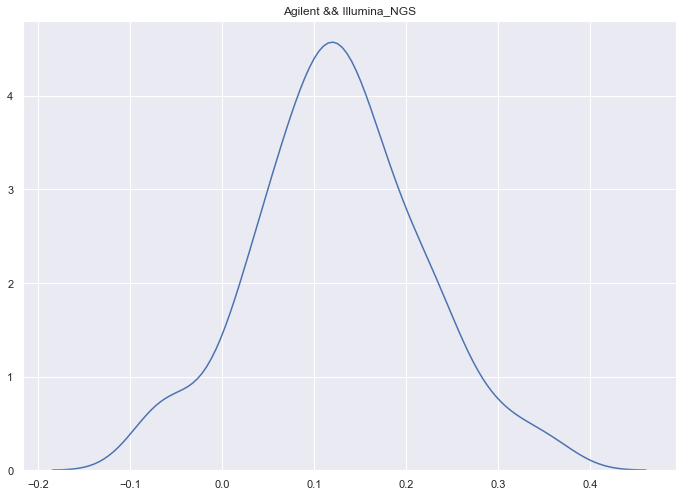

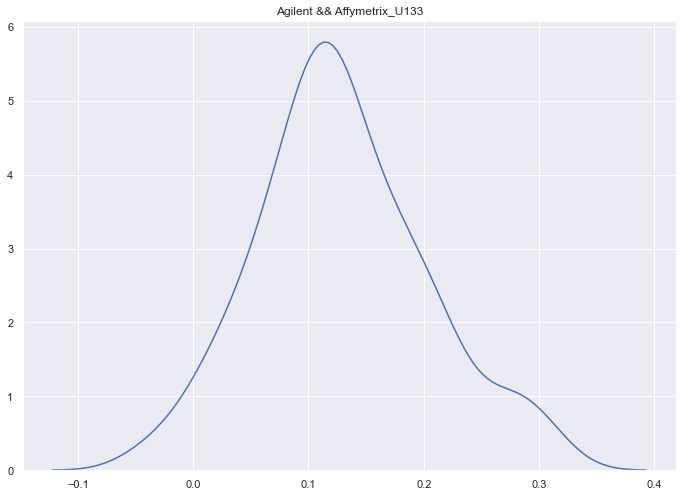

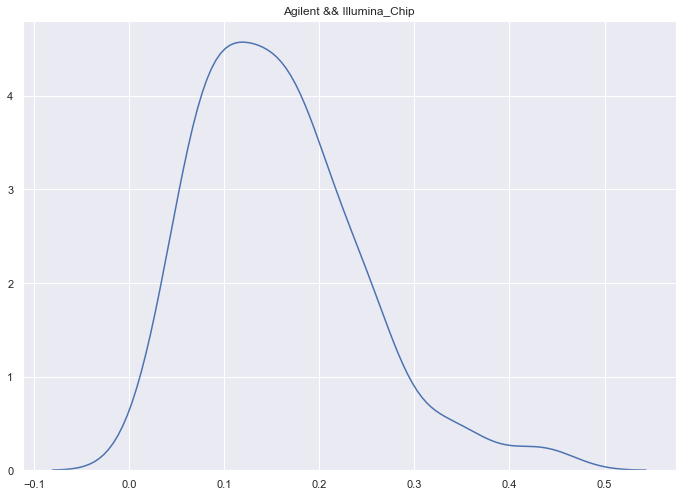

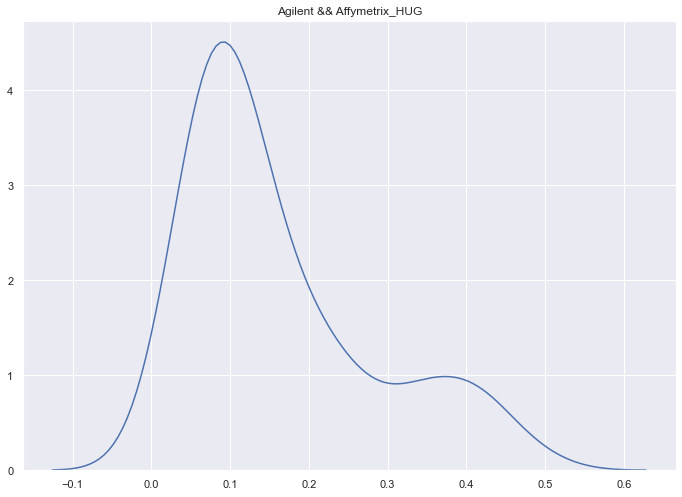

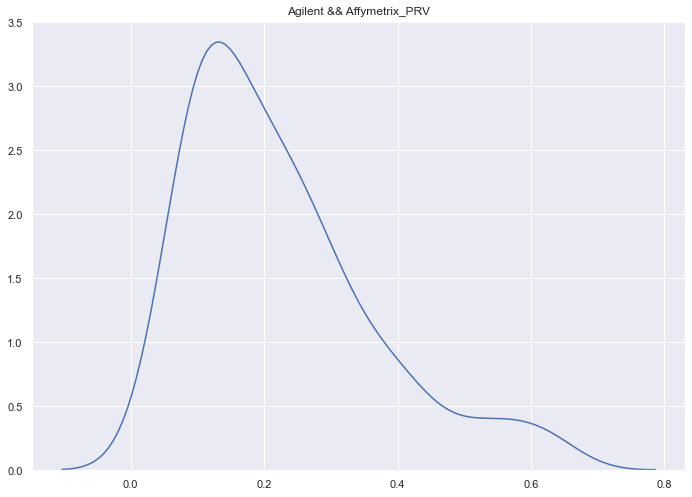

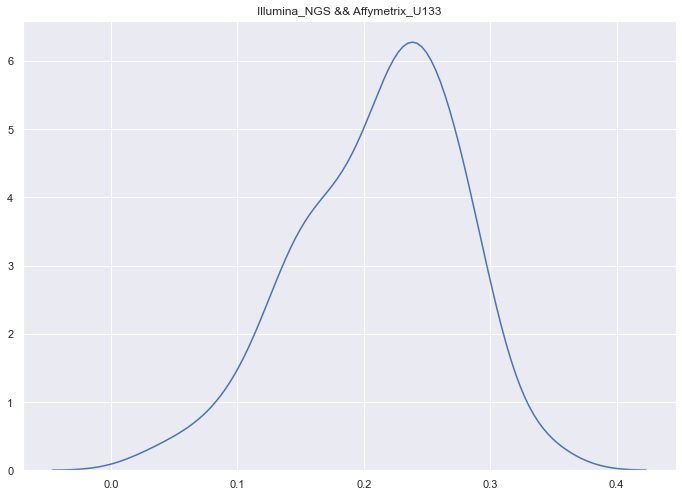

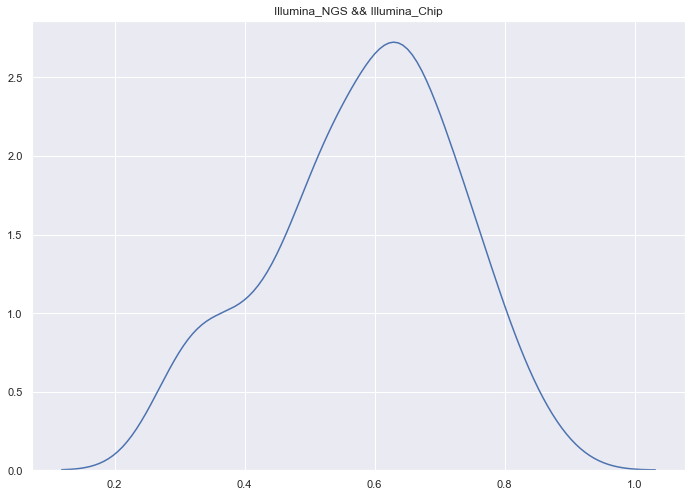

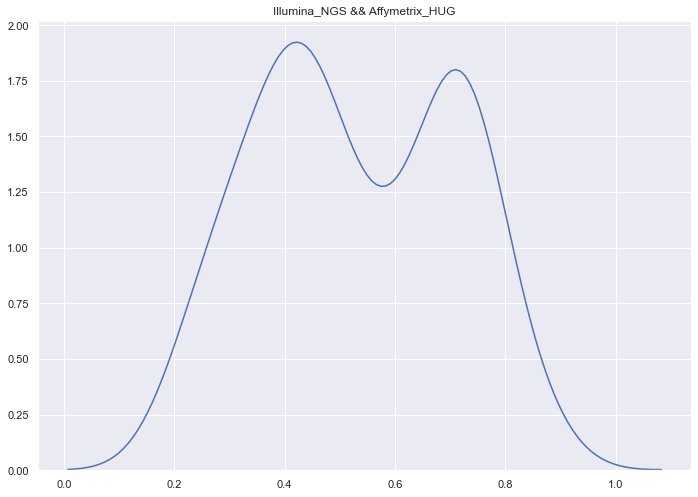

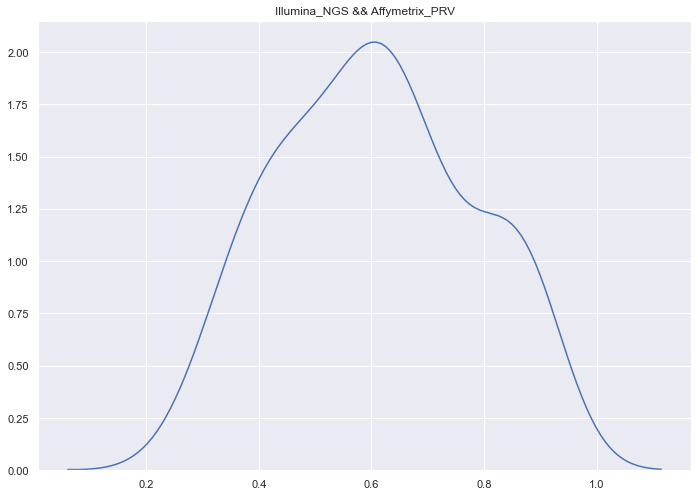

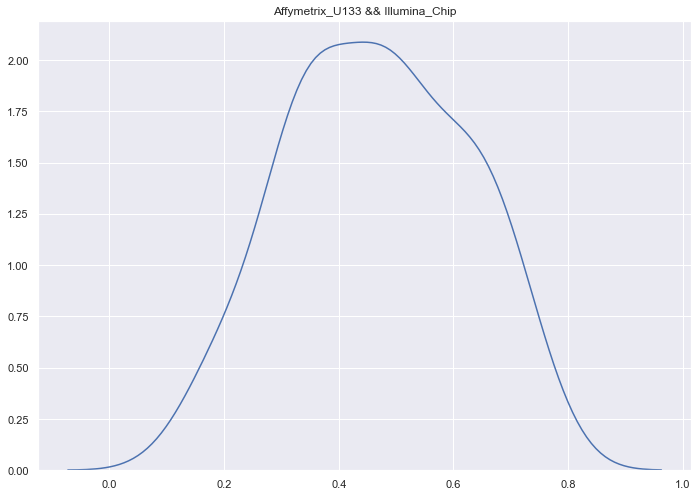

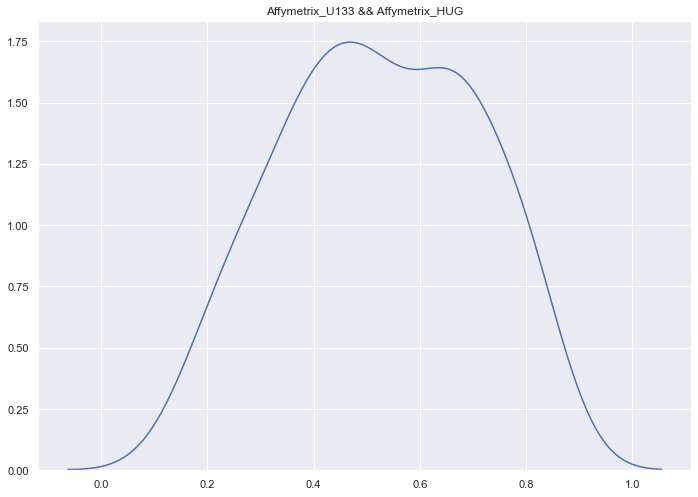

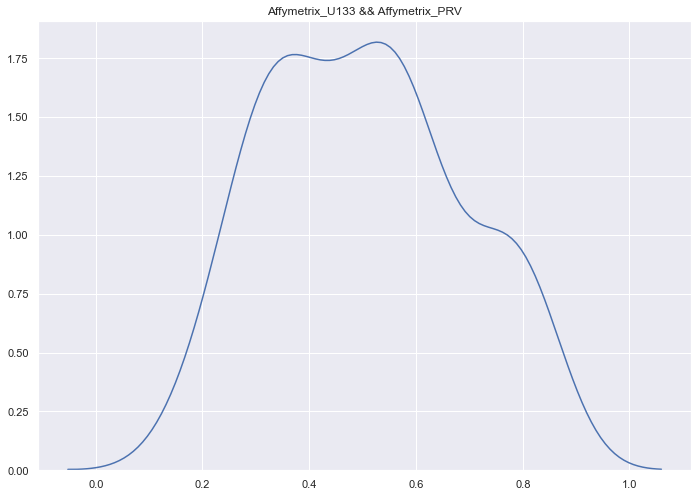

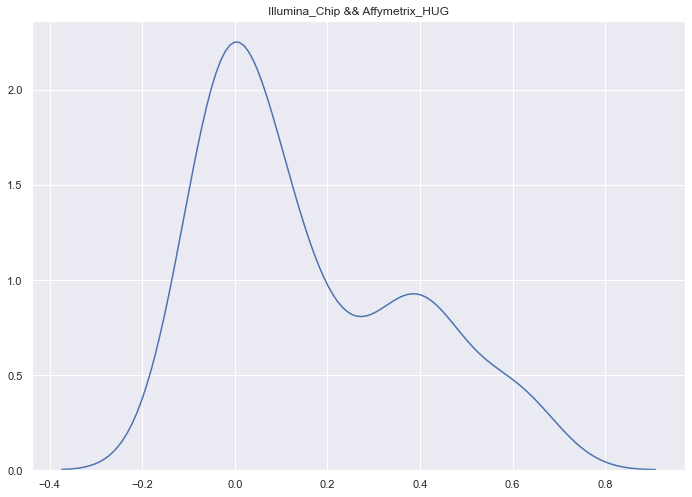

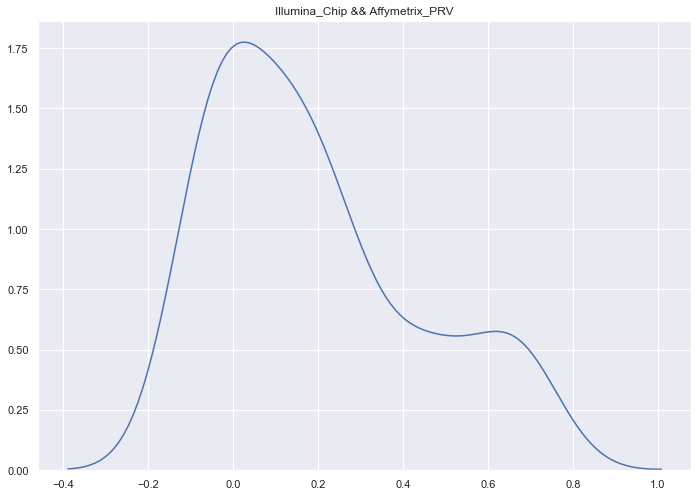

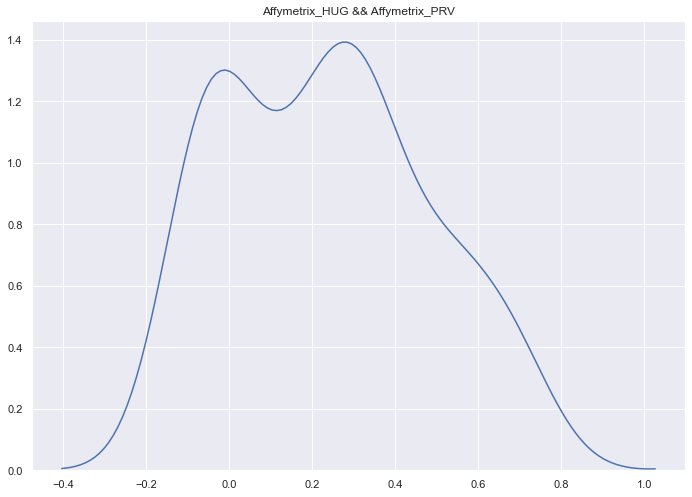

In [17]:
for idx_1, title_1 in enumerate(meta['plat'].unique()):
    for idx_2, title_2 in enumerate(meta['plat'].unique()):
        
        if(idx_2 > idx_1):
            
            plat_1 = meta[meta['plat'] == title_1]['CN']
            plat_2 = meta[meta['plat'] ==  title_2]['CN']
            
            corrs = [calc_corr(data, plat_1, plat_2) for i in range(100)]
            
            plt.figure()
            plt.title(title_1 + " && " + title_2)
            sns.distplot(corrs, hist=False)